Read the BikeSharing data, and plot against some of the parameters.    

# Initial Data Exploration

In [127]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as pp
import seaborn as sn


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Load the data, and take an initial look to get a lay of the land. 
We will generate a visualization for the correlation between all the features.  This will show us which parameters are likely to be most useful in prediction. 

In [128]:
# Read the data
mydata = pd.read_csv('train.csv') 
# Decode the date time. 
from datetime import datetime
mydata['date'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in mydata.datetime]
mydata['hour'] = [x.hour for x in mydata.date]
mydata['month'] = [x.month for x in mydata.date]
mydata['day'] = [x.day for x in mydata.date]
mydata['year'] = [x.year for x in mydata.date]
mydata['time'] = [x.month + 12*(x.year) for x in mydata.date]
mydata['dayofweek'] = [x.weekday() for x in mydata.date]



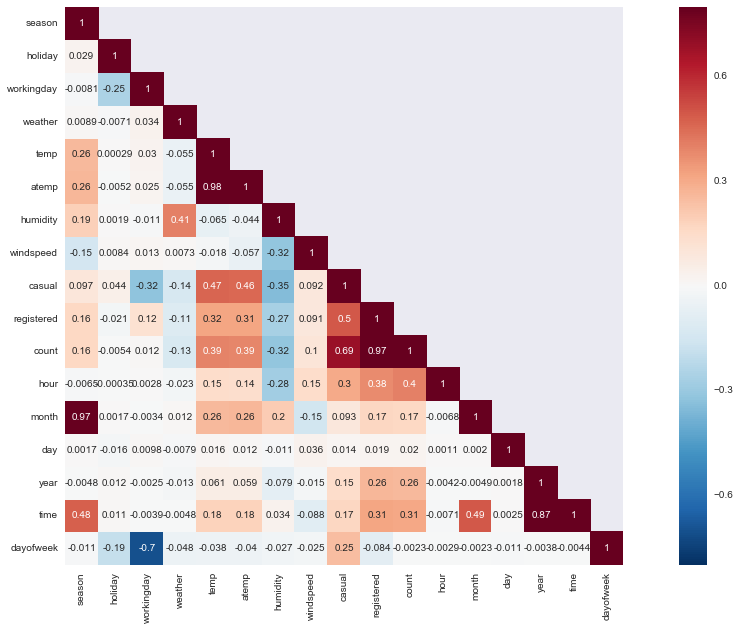

In [129]:
corrMatt = mydata.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

The plot above shows the correlation amongst all the features. 
We are interested in count, casual and registered, which appear to be most correlated with hour, temp, humidity. 
Let's make a few plots to get an idea of the relationship. 

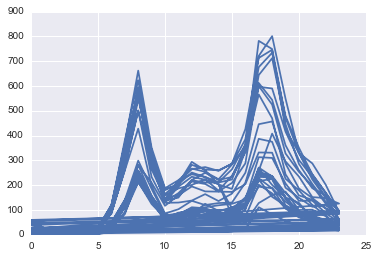

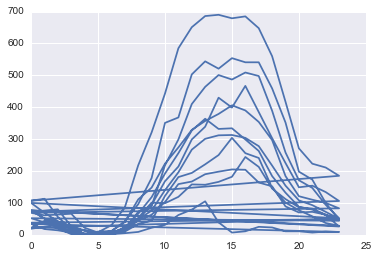

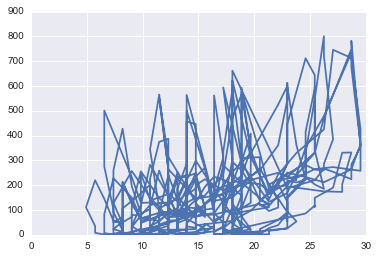

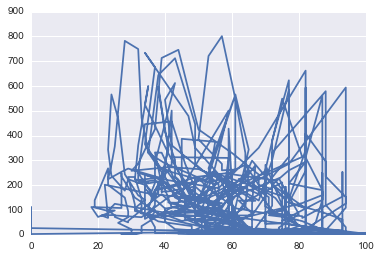

In [130]:
mon = 2
subset = mydata[mydata.month == mon+1]
wset = subset[subset.workingday==1]
nwset = subset[subset.workingday==0]

pyplot.plot(wset['hour'], wset['count'])
pyplot.show()
pyplot.plot(nwset['hour'], nwset['count'])
pyplot.show()
pyplot.plot(wset.temp, wset['count'])
pyplot.show()
pyplot.plot(wset.humidity, wset['count'])
pyplot.show()

We notice several things: 
    1.  During the working days, there are two clear peaks around hours 8 and 17 -- start/end of working day. 
    2.  During the non-working days, there is a clear peak around hour 15.
    3.  The relationship to temp and humidity isn't very clear, though there is a upward trend with higher temperatures. 
To address 1 and 2, we will have to generate new features.  Polynomial regression fit cannot give the peaks that we observed.  Also, we will need to have two predictors -- one for working days and one for non-working days. 

In [131]:
# engineer some features to address the demand peak at certain hours. 
mydata['hour_inverse_1'] = [(1/(abs(x-8) + 1))for x in mydata['hour']]
mydata['hour_inverse_2'] = [(1/(abs(x-17) + 1))for x in mydata['hour']]
#Add new features to fit peaks during late afternoons on weekends/holidays
mydata['hour_inverse_3'] = [(1/(abs(x-15) + 10))for x in mydata['hour']]
mydata['time'] = [x.day + 31*(x.month-1) + 12*(x.year) for x in mydata.date]

Clearly, linear regression will not get us anywhere here. 
Use a polynomial predictor. 
We have the first 20days for each month as training data.  For validation, use the first 15days for training, and the next 5 days as test. 
Other options to try would be
-  Use all the data before the test days for prediction
-  Use 1-2 months' data before the test days for prediction. 

In [133]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn import linear_model

all_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
            'windspeed', 'dayofweek', 'hour']

testdata = mydata.loc[mydata['day'] >15]
firstday = mydata.iloc[0].time
predictors_working  ={}
sfm_working = {}
for y in testdata['year'].unique():
    for m in testdata['month'].unique():
        test_slice = testdata.loc[(testdata['year'] == y) & (testdata['month'] == m)]
        start = max(firstday, 12*y +31*(m-1) )  #start previous month
        stop = 12*y +31*(m-1) + 15
        mydata_slice = mydata.loc[(mydata['time'] >= start) & (mydata['time'] <=stop)]

        mydata_working = mydata_slice.loc[(mydata_slice['workingday'] == 1)]
        mydata_nonworking = mydata_slice.loc[(mydata_slice['workingday'] == 0)]
        
        testdata_working = test_slice.loc[(test_slice['workingday']==1)]
        testdata_nonworking = test_slice.loc[(test_slice['workingday']==0)]
        
                    
        ## Estimator for working days: 

        features = ['temp', 'hour', 'hour_inverse_1', 'hour_inverse_2', 'humidity', 'windspeed', 'atemp', 'weather']
                    
        poly = PolynomialFeatures(degree=3)
        train_ = poly.fit_transform(mydata_working[features])        
        test_ = poly.fit_transform(testdata_working[features])        
        
        # Use Ridge with normalization
        clf_working = linear_model.Ridge(normalize=True)
        clf_working.fit(train_, mydata_working['count'])
       # pp.plot(clf.coef_)
       # pp.ylabel('Coefficients')
       # pp.xlabel('Feature')
       # pp.show()
        #Put a threshold -- we dont' want to overfit to the trainging set so we should ignore the coeff that are very small. 
        sfm = SelectFromModel(clf_working, threshold= 0.05)

        sfm.fit(train_, mydata_working['count'])
        train_n_features = sfm.transform(train_)
        test_n_features = sfm.transform(test_)
        sfm_working[m+12*y] = sfm
        
        #Fit again with trimmed features. 
        clf_working.fit(train_n_features, mydata_working['count'])
        predictors_working[m+12*y] = clf_working
        
        #prediction
        prediction = clf_working.predict(test_n_features)
        prediction = [int(x) if(x>0) else 0 for x in prediction]
        # Use this metric to fine tune the parameters. 
        m = prediction - testdata_working['count']
        m = sum(m)
        print m
       
 

-111
2012
1054
1114
2465
-493
1197
1760
-2754
2685
5124
739
-910
-520
-2576
-2328
-3309
-1213
-1751
-6369
-2371
-5403
-1594
-762


Let's take a look at one of the predictions: 

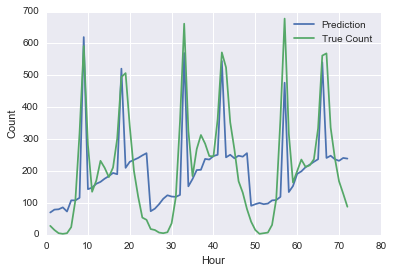

In [134]:
pyplot.figure()
pp.plot(range(1, len(prediction)+1), prediction, label='Prediction')
pp.plot(range(1, len(prediction)+1), testdata_working['count'], label='True Count')
pp.xlabel('Hour')
pp.ylabel('Count')
pp.legend()
pp.show()

Following the same approach, we will generate a model for non-working days. 

In [137]:
# Estimator for weekends:
testdata = mydata.loc[mydata['day'] >10]
firstday = mydata.iloc[0].time
predictors_nonworking  ={}
sfm_nonworking={}
for y in testdata['year'].unique():
    for m in testdata['month'].unique():
        test_slice = testdata.loc[(testdata['year'] == y) & (testdata['month'] == m)]
        start = max(firstday, 12*y +31*(m-1-2) )  #start previous month
        stop = 12*y +31*(m-1) + 10
        mydata_slice = mydata.loc[(mydata['time'] >= start) & (mydata['time'] <=stop)]

        mydata_working = mydata_slice.loc[(mydata_slice['workingday'] == 1)]
        mydata_nonworking = mydata_slice.loc[(mydata_slice['workingday'] == 0)]
        
        testdata_working = test_slice.loc[(test_slice['workingday']==1)]
        testdata_nonworking = test_slice.loc[(test_slice['workingday']==0)]
        
                    
        ## Estimator for non-working days: 

        features = ['temp', 'hour', 'humidity', 'windspeed', 'atemp', 'weather', 'hour_inverse_3', 'weather', 'month', 'year']
                  
        poly = PolynomialFeatures(degree=3)
        train_ = poly.fit_transform(mydata_nonworking[features])        
        test_ = poly.fit_transform(testdata_nonworking[features])        
        
        # Use Ridge with normalization
        clf_nonworking = linear_model.Ridge(normalize=True)
        clf_nonworking.fit(train_, mydata_nonworking['count'])
       # pp.plot(clf.coef_)
       # pp.ylabel('Coefficients')
       # pp.xlabel('Feature')
       # pp.show()
        #Put a threshold -- we dont' want to overfit to the trainging set so we should ignore the coeff that are very small. 
        sfm = SelectFromModel(clf_nonworking, threshold= 0.05)

        sfm.fit(train_, mydata_nonworking['count'])
        train_n_features = sfm.transform(train_)
        test_n_features = sfm.transform(test_)
        sfm_nonworking[m+12*y] = sfm
        #Fit again with trimmed features. 
        clf_nonworking.fit(train_n_features, mydata_nonworking['count'])
        predictors_nonworking[m+12*y] = clf_nonworking
        
        #prediction
        prediction = clf_nonworking.predict(test_n_features)
        prediction = [int(x) if(x>0) else 0 for x in prediction]
        # Use this metric to fine tune the parameters. 
        m = prediction - testdata_nonworking['count']
        m = sum(m)
        print m

-814
3346
-71
3524
-157
7997
-812
-1598
-5204
2734
5986
-195
-1778
-1897
-7783
-750
-1328
-1910
-4842
-7424
-4214
-2730
-4614
514


Let's take a look at one of the predictions:

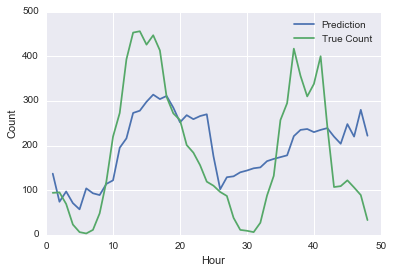

In [138]:
pyplot.figure()
pp.plot(range(1, len(prediction)+1), prediction, label='Prediction')
pp.plot(range(1, len(prediction)+1), testdata_nonworking['count'], label='True Count')
pp.xlabel('Hour')
pp.ylabel('Count')
pp.legend()
pp.show()


Using the same model for testing data also: 

In [140]:
testdata = pd.read_csv('test.csv')
testdata['date'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in testdata.datetime]
testdata['hour'] = [x.hour for x in testdata.date]
testdata['month'] = [x.month for x in testdata.date]
testdata['day'] = [x.day for x in testdata.date]
testdata['year'] = [x.year for x in testdata.date]

testdata['hour_inverse_1'] = [(1/(abs(x-8) + 1))for x in testdata['hour']]
testdata['hour_inverse_2'] = [(1/(abs(x-17) + 1))for x in testdata['hour']]
testdata['hour_inverse_3'] = [(1/(abs(x-15) + 10))for x in testdata['hour']]
testdata['time'] = [x.day + 31*(x.month-1) + 12*(x.year) for x in testdata.date]
testdata['prediction_count'] = 0

for y in testdata['year'].unique():
    for m in testdata['month'].unique():
        test_slice = testdata.loc[(testdata['year'] == y) & (testdata['month'] == m)]
        testdata_working = test_slice.loc[(test_slice['workingday']==1)]
        testdata_nonworking = test_slice.loc[(test_slice['workingday']==0)]
        
                    
        ## Estimator for non-working days: 
        features = ['temp', 'hour', 'humidity', 'windspeed', 'atemp', 'weather', 'hour_inverse_3', 'weather', 'month', 'year']
                  
        poly = PolynomialFeatures(degree=3)
        test_ = poly.fit_transform(testdata_nonworking[features])        
        test_n_features = sfm_nonworking[m+12*y].transform(test_)
        #prediction
        prediction = predictors_nonworking[m+12*y].predict(test_n_features)
        prediction = [int(x) if(x>0) else 0 for x in prediction]
        testdata.loc[(testdata['year'] == y) & (testdata['month'] == m) & (testdata['workingday'] == 0), 'prediction_count'] = prediction
        
        #Prediction for working days:
        features = ['temp', 'hour', 'hour_inverse_1', 'hour_inverse_2', 'humidity', 'windspeed', 'atemp', 'weather']            
        poly = PolynomialFeatures(degree=3)
        test_ = poly.fit_transform(testdata_working[features])        
        
        test_n_features = sfm_working[m+12*y].transform(test_)
        #prediction
        prediction = predictors_working[m+12*y].predict(test_n_features)
        prediction = [int(x) if(x>0) else 0 for x in prediction]
        testdata.loc[(testdata['year'] == y) & (testdata['month'] == m) & (testdata['workingday'] == 1), 'prediction_count'] = prediction

submission = pd.DataFrame({'datetime':testdata['datetime'],
                           'count': testdata['prediction_count']})
submission.to_csv('bikeSharing.csv', index=False)      